In [111]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [112]:
import kagglehub
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, random_split

from trainer import Trainer

#import Dataloader
from dataloader import ImageColorizerDataset

#import architectures
from neural_nets import ImageColorizer, ImageSuperRes, UNet, UNetRes
from grid_search import run_grid_search, plot_results

In [113]:
# Download latest version
IMAGE_PATH = kagglehub.dataset_download("arnaud58/landscape-pictures")
print("Path to dataset files:", IMAGE_PATH)

Path to dataset files: /home/gabri/.cache/kagglehub/datasets/arnaud58/landscape-pictures/versions/2


In [121]:
# 2. Device config
device = torch.device(
    'mps' if torch.backends.mps.is_available()
    else 'cuda' if torch.cuda.is_available()
    else 'cpu'
)

print(f'Using device: {device}')

Using device: cuda


In [102]:
# 3. Hyperparameters
img_height, img_width = 128, 128
batch_size            = 32
num_epochs            = 20
learning_rate         = 1e-3

Using device: cuda
Testing size=(96, 96), lr=0.01, bs=16, epochs=1


Epoch 1/1 — Train Loss: 0.0450 | Val Loss: 0.0152
Grid Search abgeschlossen. Beste Konfiguration: ((96, 96), 0.01, 16, 1), loss=0.0152


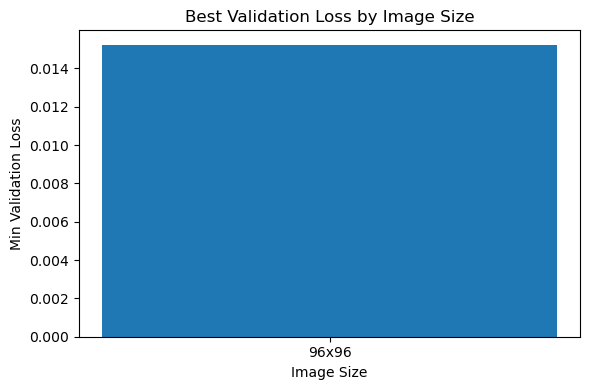

In [122]:
# 3.1 Hyperparameters with Grid-Search
grid = {
    'img_size': [(96,96), (128,128), (180,180)],
    'lr':       [1e-2, 1e-3, 1e-4],
    'bs':       [16, 32],
    'epochs':   [1, 2],
}
df_results = run_grid_search(IMAGE_PATH, grid)
plot_results(df_results)

In [103]:
# 4. DataLoader
dataset   = ImageColorizerDataset(IMAGE_PATH, img_height, img_width)

val_frac  = 0.1
n_total   = len(dataset)
n_val     = int(n_total * val_frac)
n_train   = n_total - n_val

# 5. Splitten
train_ds, val_ds = random_split(dataset, [n_train, n_val])

train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True, num_workers=4)
val_loader = DataLoader(val_ds, batch_size=batch_size, shuffle=False, num_workers=4)
print(f'Loaded {len(dataset)} images.')

Loaded 2151 images.


In [104]:
model = ImageColorizer(in_channels=1, out_channels=3)                               #UNetResidual
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
print(model)

ImageColorizer(
  (enc1): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (enc2): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (enc3): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (up1): Upsample(scale_factor=2.0, mode='nearest')
  (dec1): Conv2d(256, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (up2): Upsample(scale_factor=2.0, mode='nearest')
  (dec2): Conv2d(128, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (final): Conv2d(64, 3, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu): ReLU(inplace=True)
  (sigmoid): Sigmoid()
)


Epoch 1/20 — Train Loss: 0.0244 | Val Loss: 0.0148


Epoch 2/20 — Train Loss: 0.0144 | Val Loss: 0.0131


Epoch 3/20 — Train Loss: 0.0129 | Val Loss: 0.0117


Epoch 4/20 — Train Loss: 0.0121 | Val Loss: 0.0125


Epoch 5/20 — Train Loss: 0.0117 | Val Loss: 0.0107


Epoch 6/20 — Train Loss: 0.0115 | Val Loss: 0.0104


Epoch 7/20 — Train Loss: 0.0109 | Val Loss: 0.0099


Epoch 8/20 — Train Loss: 0.0105 | Val Loss: 0.0102


Epoch 9/20 — Train Loss: 0.0107 | Val Loss: 0.0097


Epoch 10/20 — Train Loss: 0.0107 | Val Loss: 0.0099


Epoch 11/20 — Train Loss: 0.0106 | Val Loss: 0.0100


Epoch 12/20 — Train Loss: 0.0102 | Val Loss: 0.0097


Epoch 13/20 — Train Loss: 0.0102 | Val Loss: 0.0102


Epoch 14/20 — Train Loss: 0.0101 | Val Loss: 0.0100


Epoch 15/20 — Train Loss: 0.0101 | Val Loss: 0.0095


Epoch 16/20 — Train Loss: 0.0100 | Val Loss: 0.0091


Epoch 17/20 — Train Loss: 0.0099 | Val Loss: 0.0091


Epoch 18/20 — Train Loss: 0.0096 | Val Loss: 0.0094


Epoch 19/20 — Train Loss: 0.0097 | Val Loss: 0.0090


Epoch 20/20 — Train Loss: 0.0095 | Val Loss: 0.0088


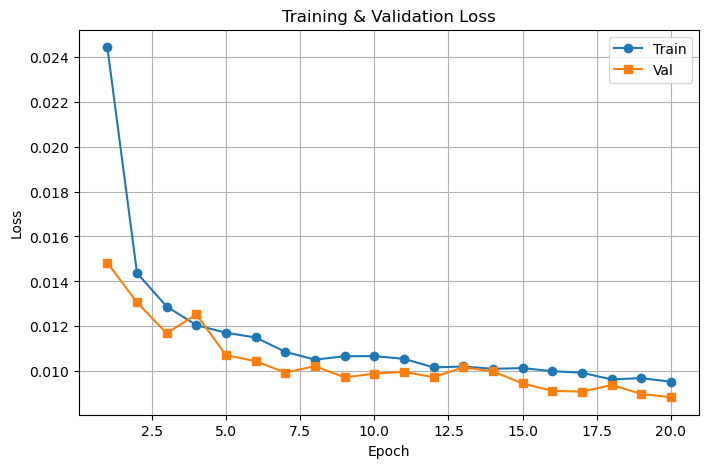

In [105]:
trainer = Trainer(model, train_loader, val_loader, criterion, optimizer, device)
trainer.fit(num_epochs)

# 6. Lernkurve anzeigen
trainer.plot_history()

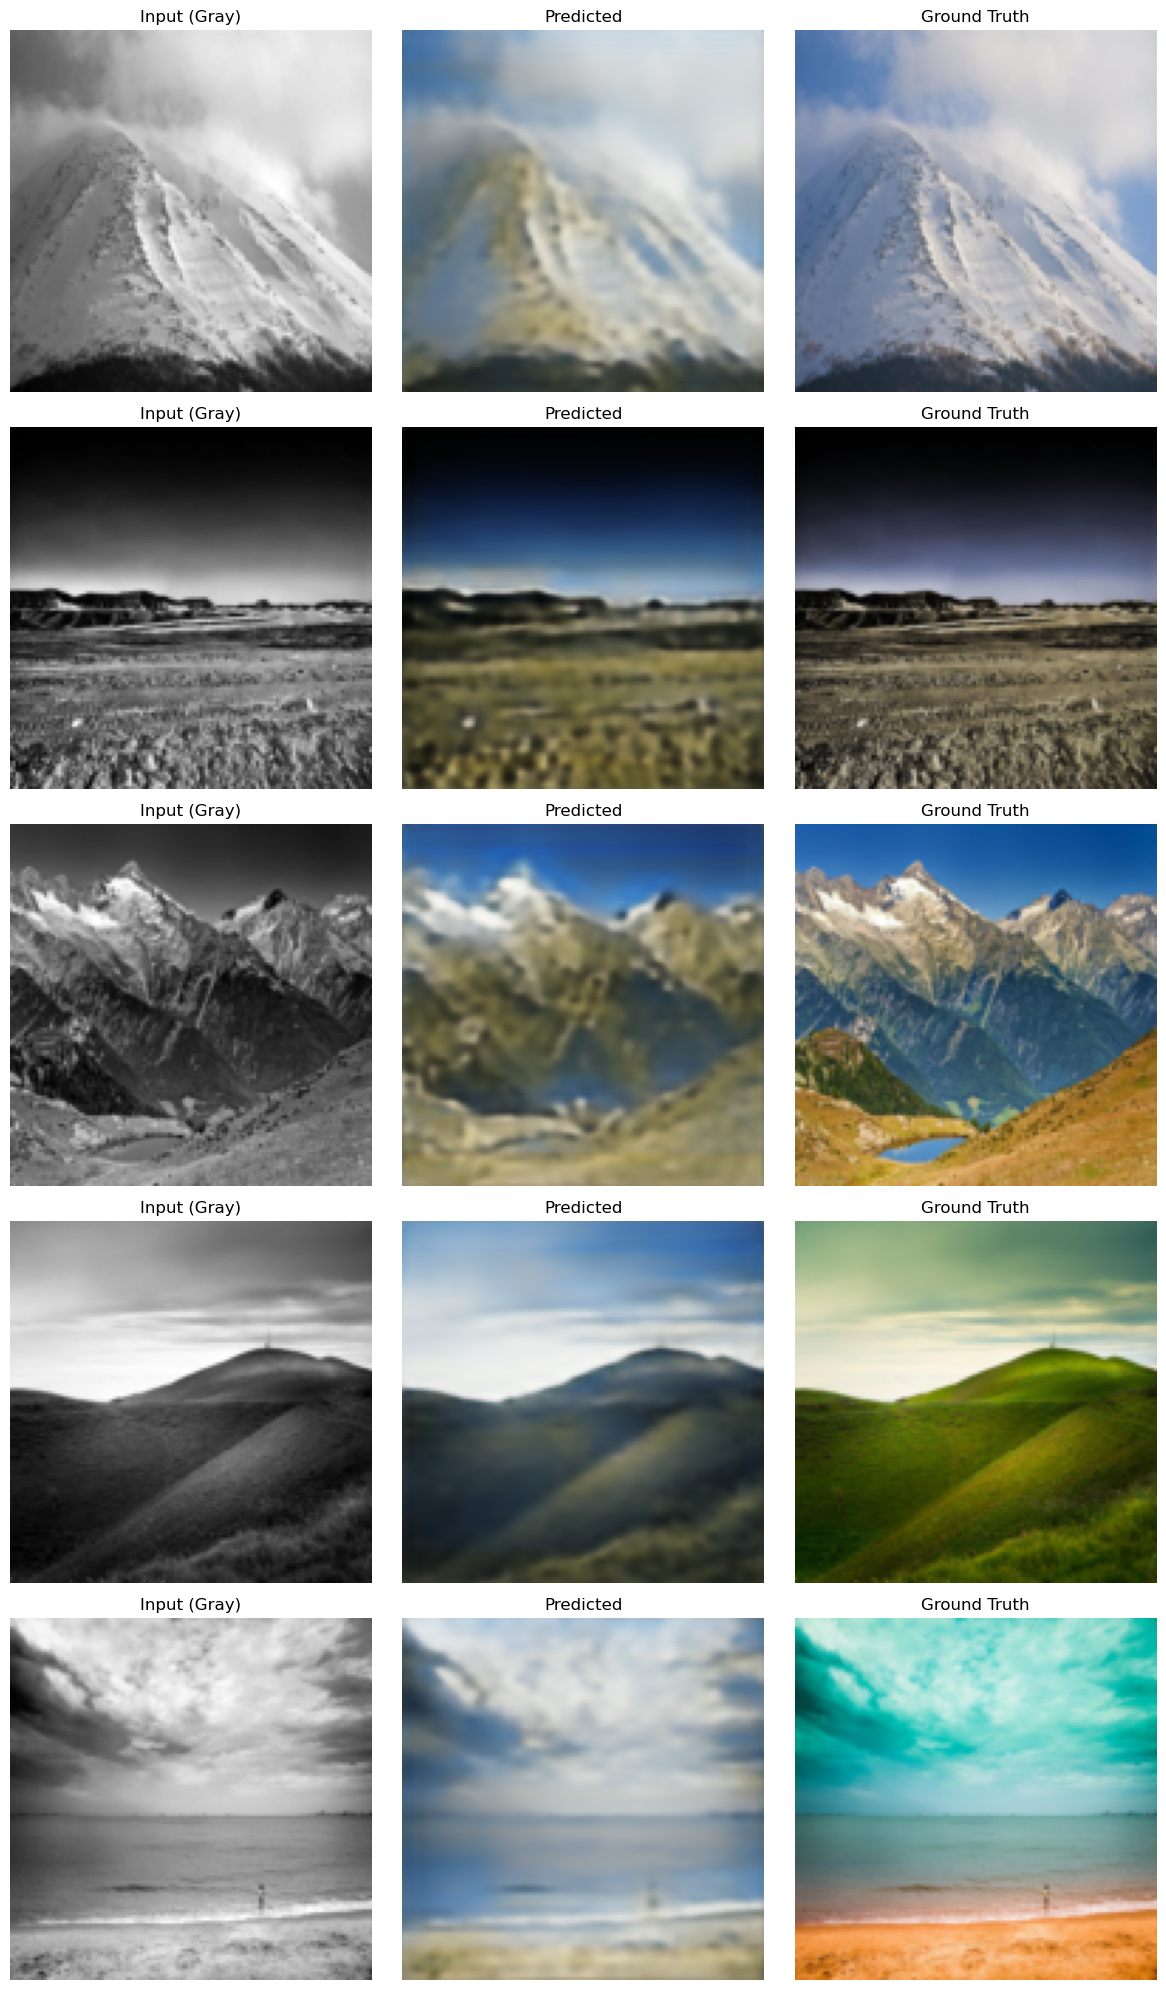

In [106]:
#acthung Test LOADER erzeugen!!!!
trainer.show_examples(val_loader)